# Genetics Application

For this set of questions, we will explore the use of Convolutional Neural Networks to solve a problem with Biological significance (don't worry, no background knowledge is expected). Every cell in your body contains Deoxyribonucleic acid (DNA), which is essentially the instructions for making all the proteins in your body. DNA can be thought of as a very long string where the alphabet is \{A,C,T,G\}.
The physical attributes of the DNA string and its characters are not important here, except that ~98% of our DNA is physically inaccessible to external molecules. Understanding which regions of DNA are accessible and why is of great interest to scientists. This motivates learning predictive models which could accurately classify such regions. In particular, we will be implementing the deep network called [Basset](https://pubmed.ncbi.nlm.nih.gov/27197224/).


In [1]:
#@title Mount your Google Drive
%matplotlib inline
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from tqdm import tqdm

In [3]:
#@title Link your assignment folder & install requirements
#@markdown Enter the path to the assignment folder in your Google Drive
import sys
import os
import shutil
import warnings

folder = "/content/gdrive/MyDrive/IFT6135_A1_Data" #@param {type:"string"}
!ln -Ts $folder /content/IFT6135_A1_Data 2> /dev/null

# Add the assignment folder to Python path
if '/content/IFT6135_A1_Data' not in sys.path:
    sys.path.insert(0, '/content/IFT6135_A1_Data')

# Install requirements
# !pip install -qr /content/IFT6135_A1_Data/requirements.txt

# Check if CUDA is available
import torch
if not torch.cuda.is_available():
    warnings.warn('CUDA is not available.')

In [4]:
!unzip /content/gdrive/MyDrive/IFT6135_A1_Data/er.zip


Archive:  /content/gdrive/MyDrive/IFT6135_A1_Data/er.zip
  inflating: er.h5                   


In [5]:
import os
# unzip data
if not os.path.exists('/content/A1/er.h5'):
    os.system('unzip /content/A1/er.zip')
    os.system('mv /content/er.h5 /content/A1/er.h5')
    print("done")

done


In [6]:
if not os.path.exists('/content/A1/er.h5'):
  print("S")

S


## Running on GPU
In Google Colab, you can run your code on GPU. This will be particularly important in CNN part of the assignment. To make sure the notebook is running on GPU, you can change the notebook settings with
* (EN) `Edit > Notebook Settings`
* (FR) `Modifier > Paramètres du notebook`

Be mindful not to use the GPU if your code does not need to run on GPU.

In [7]:
import random

import numpy as np
import h5py
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

# import solution

In [8]:
# The hyperparameters we will use
batch_size = 64
learning_rate = 0.002

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# set RNG
seed = 42
torch.backends.cudnn.deterministic = True
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if device.type=='cuda':
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [10]:
device.type

'cuda'

Let's build the dataset that we will be using. Before doing any machine learning, you should always inspect the data you will be using (especially when that data is uncommon)!

In our case, the input data are subsequences of DNA that come from the reference human genome HG19. HG19 can be thought of as the DNA of a prototypical human (but it does not come from any single person).
The input data is one-hot encoded, such that:

$$A = \begin{pmatrix} 1 \\ 0 \\ 0 \\ 0 \end{pmatrix}, C = \begin{pmatrix} 0 \\ 1 \\ 0 \\ 0 \end{pmatrix}, G = \begin{pmatrix} 0 \\ 0 \\ 1 \\ 0 \end{pmatrix}, T = \begin{pmatrix} 0 \\ 0 \\ 0 \\ 1 \end{pmatrix}$$

Each base-pair $\{A,C,G,T\}$ are concatenated along the length of the sequence. Each data point is equivalent to an image with a rectangular shape (sequence length, 4) and a single channel for data processing purposes.

The target data for our sequence are binary strings encoded as $1$ if the DNA subsequence is accessible and $0$ if it is not. This data was collected across experiments. For each sample, the target is a vector of size 164, with $1$s in the indices of the experiments where the DNA is accessible and $0$ otherwise.

# **Question 1 (Understanding the Data)** 
(10 points). You will notice that PyTorch is very object-oriented -- everything you use is the subclass of a PyTorch class. For datasets, we subclass `torch.utils.data.Dataset`.

1. Define the `__getitem__` and `__len__` methods for the `BassetDataset` class in `solution.py`
2. What is the length of each sequence we will feed into our model?  Make the `get_seq_len` method of the `BassetDataset` class to return it.
3. Is it true that each data point is also equivalent to an image with a rectangular shape (1, sequence length) with 4 channels? Write the method `is_equvalent` to return your answer (either return True or False).

Note: this data has already been pre-processed, so do not include any additional data transformations!

In [11]:
# investigate your data
f = h5py.File('er.h5', 'r')
print(f.keys())
f.close()

<KeysViewHDF5 ['target_labels', 'test_headers', 'test_in', 'test_out', 'train_in', 'train_out', 'valid_in', 'valid_out']>


In [12]:
dataset = h5py.File('er.h5', 'r')

target_labels = dataset['target_labels']

split_dict = {'train': ['train_in', 'train_out'],
                      'test': ['test_in', 'test_out'],
                      'valid': ['valid_in', 'valid_out']}
                      
inputs = dataset[split_dict["train"][0]]
outputs = dataset[split_dict["train"][1]]

ids = list(range(len(inputs)))
# if self.split == 'test':
#   self.id_vars = np.char.decode(self.dataset['test_headers'])

In [13]:
i = 100
idx = ids[i]

seq = inputs[idx]
target = outputs[idx]
print(seq.shape)
print(seq)
seq = np.transpose(seq, (1, 2, 0)).astype(np.float32)
print(seq.shape)
print(torch.Tensor(seq).shape)
target = np.float32(target)
output = {'sequence': torch.Tensor(seq), 
          'target': torch.Tensor(target)}

(4, 1, 600)
[[[0. 0. 0. ... 0. 1. 0.]]

 [[0. 0. 0. ... 1. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]]

 [[0. 1. 1. ... 0. 0. 1.]]]
(1, 600, 4)
torch.Size([1, 600, 4])


In [14]:
import os
import random

import numpy as np
import torch
import h5py
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class BassetDataset(Dataset):
    """
    BassetDataset class taken with permission from Dr. Ahmad Pesaranghader

    We have already processed the data in HDF5 format: er.h5
    See https://www.h5py.org/ for details of the Python package used

    We used the same data processing pipeline as the paper.
    You can find the code here: https://github.com/davek44/Basset
    """

    # Initializes the BassetDataset
    def __init__(self, path='', f5name='er.h5', split='train', transform=None):
        """
        Args:
            :param path: path to HDF5 file
            :param f5name: HDF5 file name
            :param split: split that we are interested to work with
            :param transform (callable, optional): Optional transform to be applied on a sample
        """

        self.split = split

        split_dict = {'train': ['train_in', 'train_out'],
                      'test': ['test_in', 'test_out'],
                      'valid': ['valid_in', 'valid_out']}

        assert self.split in split_dict, "'split' argument can be only defined as 'train', 'valid' or 'test'"

        # Open hdf5 file where one-hoted data are stored
        self.dataset = h5py.File(os.path.join(path, f5name.format(self.split)), 'r')

        # Keeping track of the names of the target labels
        self.target_labels = self.dataset['target_labels']

        # Get the list of volumes
        self.inputs = self.dataset[split_dict[split][0]]
        self.outputs = self.dataset[split_dict[split][1]]

        self.ids = list(range(len(self.inputs)))
        if self.split == 'test':
            self.id_vars = np.char.decode(self.dataset['test_headers'])

    def __getitem__(self, i):
        """
        Returns the sequence and the target at index i

        Notes:
        * The data is stored as float16, however, your model will expect float32.
          Do the type conversion here!
        * Pay attention to the output shape of the data.
          Change it to match what the model is expecting
          hint: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        * The target must also be converted to float32
        """

        idx = self.ids[i]
        # WRITE CODE HERE

        seq = self.inputs[idx]
        target = self.outputs[idx]

        seq = np.transpose(seq, (1, 2, 0)).astype(np.float32)
        target = np.float32(target)
        # Sequence & Target
        output = {'sequence': torch.Tensor(seq), 
                  'target': torch.Tensor(target)}
        return output

    def __len__(self):
        # WRITE CODE HERE
        return len(self.inputs)

    def get_seq_len(self):
        """
        Answer to Q1 part 2
        """
        # WRITE CODE HERE
        return self.inputs[0].shape[-1]

    def is_equivalent(self):
        """
        Answer to Q1 part 3
        """
        # WRITE CODE HERE
        return True

In [18]:
basset_dataset_train = BassetDataset(path='', f5name='er.h5', split='train')
basset_dataset_valid = BassetDataset(path='', f5name='er.h5', split='valid')
basset_dataset_test = BassetDataset(path='', f5name='er.h5', split='test')
basset_dataloader_train = DataLoader(basset_dataset_train,
                                     batch_size=batch_size,
                                     drop_last=True,
                                     shuffle=True,
                                     num_workers=1)
basset_dataloader_valid = DataLoader(basset_dataset_valid,
                                     batch_size=batch_size,
                                     drop_last=True,
                                     shuffle=False,
                                     num_workers=1)
basset_dataloader_test = DataLoader(basset_dataset_test,
                                    batch_size=batch_size,
                                    drop_last=True,
                                    shuffle=False,
                                    num_workers=1)

In [16]:
for i, sample in enumerate(basset_dataloader_test):
  print(i)
  print(sample)
  print(sample["sequence"].shape)
  print(sample["target"].shape)
  break

0
{'sequence': tensor([[[[0., 1., 0., 0.],
          [0., 0., 0., 1.],
          [0., 1., 0., 0.],
          ...,
          [1., 0., 0., 0.],
          [1., 0., 0., 0.],
          [1., 0., 0., 0.]]],


        [[[0., 1., 0., 0.],
          [0., 0., 0., 1.],
          [0., 0., 0., 1.],
          ...,
          [0., 1., 0., 0.],
          [0., 1., 0., 0.],
          [0., 0., 0., 1.]]],


        [[[1., 0., 0., 0.],
          [0., 1., 0., 0.],
          [0., 1., 0., 0.],
          ...,
          [1., 0., 0., 0.],
          [0., 0., 0., 1.],
          [1., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0., 1.],
          [0., 0., 1., 0.],
          [0., 0., 0., 1.],
          ...,
          [0., 1., 0., 0.],
          [1., 0., 0., 0.],
          [1., 0., 0., 0.]]],


        [[[1., 0., 0., 0.],
          [0., 0., 0., 1.],
          [0., 0., 0., 1.],
          ...,
          [0., 1., 0., 0.],
          [1., 0., 0., 0.],
          [0., 0., 1., 0.]]],


        [[[0., 0., 1., 0.],
       

In [19]:
for data in basset_dataloader_valid:
  print(data.keys())
  break

dict_keys(['sequence', 'target'])


# **Question 2 (Building the Network)** 
(15 points). PyTorch also provides an abstraction for differentiable models: `torch.nn.Module`. In `solution.py`, we define Basset as a subclass of this class.

1. Fill in the missing values denoted as `?` within the class definition using [supplementary figure 13](https://genome.cshlp.org/content/suppl/2016/06/10/gr.200535.115.DC1/Supplementary_Figures.pdf) and convolution arithmetic.
2. Write the `forward` pass function. Again, please refer to [supplementary figure 13](https://genome.cshlp.org/content/suppl/2016/06/10/gr.200535.115.DC1/Supplementary_Figures.pdf).

  Do not include any output activation in your forward method! In practice, it is better to use a loss function that has the output activation built-in.

## Solution.py

In [20]:
# This script contains the helper functions you will be using for this assignment

import os
import random

import numpy as np
import torch
import h5py
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class BassetDataset(Dataset):
    """
    BassetDataset class taken with permission from Dr. Ahmad Pesaranghader

    We have already processed the data in HDF5 format: er.h5
    See https://www.h5py.org/ for details of the Python package used

    We used the same data processing pipeline as the paper.
    You can find the code here: https://github.com/davek44/Basset
    """

    # Initializes the BassetDataset
    def __init__(self, path='./data/', f5name='er.h5', split='train', transform=None):
        """
        Args:
            :param path: path to HDF5 file
            :param f5name: HDF5 file name
            :param split: split that we are interested to work with
            :param transform (callable, optional): Optional transform to be applied on a sample
        """

        self.split = split

        split_dict = {'train': ['train_in', 'train_out'],
                      'test': ['test_in', 'test_out'],
                      'valid': ['valid_in', 'valid_out']}

        assert self.split in split_dict, "'split' argument can be only defined as 'train', 'valid' or 'test'"

        # Open hdf5 file where one-hoted data are stored
        self.dataset = h5py.File(os.path.join(path, f5name.format(self.split)), 'r')

        # Keeping track of the names of the target labels
        self.target_labels = self.dataset['target_labels']

        # Get the list of volumes
        self.inputs = self.dataset[split_dict[split][0]]
        self.outputs = self.dataset[split_dict[split][1]]

        self.ids = list(range(len(self.inputs)))
        if self.split == 'test':
            self.id_vars = np.char.decode(self.dataset['test_headers'])

    def __getitem__(self, i):
        """
        Returns the sequence and the target at index i

        Notes:
        * The data is stored as float16, however, your model will expect float32.
          Do the type conversion here!
        * Pay attention to the output shape of the data.
          Change it to match what the model is expecting
          hint: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        * The target must also be converted to float32
        """

        idx = self.ids[i]
        # WRITE CODE HERE

        seq = self.inputs[idx]
        target = self.outputs[idx]

        seq = np.transpose(seq, (1, 2, 0)).astype(np.float32)
        target = np.float32(target)

        seq = torch.from_numpy(seq)
        target = torch.from_numpy(target)
        # Sequence & Target
        output = {'sequence': seq, 
                  'target': target}
        return output

    def __len__(self):
        # WRITE CODE HERE
        return len(self.inputs)

    def get_seq_len(self):
        """
        Answer to Q1 part 2
        """
        # WRITE CODE HERE
        return self.inputs[0].shape[-1]

    def is_equivalent(self):
        """
        Answer to Q1 part 3
        """
        # WRITE CODE HERE
        return True


class Basset(nn.Module):
    """
    Basset model
    Architecture specifications can be found in the supplementary material
    You will also need to use some Convolution Arithmetic
    """

    def __init__(self):
        super(Basset, self).__init__()

        self.num_cell_types = 164

        self.conv1 = nn.Conv2d(1, 300, (19, 4), stride=(1, 1), padding=(9, 0))
        self.conv2 = nn.Conv2d(300, 200, (11, 1), stride=(1, 1), padding=(5, 0))
        self.conv3 = nn.Conv2d(200 , 200, (7, 1), stride=(1, 1), padding=(4, 0))

        self.bn1 = nn.BatchNorm2d(300)
        self.bn2 = nn.BatchNorm2d(200)
        self.bn3 = nn.BatchNorm2d(200)
        self.maxpool1 = nn.MaxPool2d((3, 1))
        self.maxpool2 = nn.MaxPool2d((4, 1))
        self.maxpool3 = nn.MaxPool2d((4, 1))

        self.fc1 = nn.Linear(13*200, 1000)
        self.bn4 = nn.BatchNorm1d(1000)

        self.fc2 = nn.Linear(1000, 1000)
        self.bn5 = nn.BatchNorm1d(1000)

        self.fc3 = nn.Linear(1000, self.num_cell_types)
        self.dropout = 0.3
        self.drop = nn.Dropout(self.dropout)

    def forward(self, x):

        # WRITE CODE HERE
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.maxpool3(x)

        x = x.view(-1, 13*200)

        x = self.fc1(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.drop(x)

        x = self.fc2(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.drop(x)

        x = self.fc3(x)

        return x


def compute_fpr_tpr(y_true, y_pred):
    """
    Computes the False Positive Rate and True Positive Rate
    Args:
        :param y_true: groundtruth labels (np.array of ints)
        :param y_pred: model decisions (np.array of ints)

    :Return: dict with tpr, fpr (values are floats)
    """
    output = {'fpr': 0., 'tpr': 0.}

    # WRITE CODE HERE
    
    fp = np.sum((y_pred == 1) & (y_true == 0))
    tp = np.sum((y_pred == 1) & (y_true == 1))

    fn = np.sum((y_pred == 0) & (y_true == 1))
    tn = np.sum((y_pred == 0) & (y_true == 0))

    fpr = fp / (fp + tn)
    tpr = tp / (tp + fn)

    output = {'fpr': fpr, 'tpr': tpr}
    return output


def compute_fpr_tpr_dumb_model():
    """
    Simulates a dumb model and computes the False Positive Rate and True Positive Rate

    :Return: dict with tpr_list, fpr_list.
             These lists contain the tpr and fpr for different thresholds
             fpr and tpr values in the lists should be floats
             Order the lists such that:
                 output['fpr_list'][0] corresponds to k=0.
                 output['fpr_list'][1] corresponds to k=0.05 
                 ...
            Do the same for output['tpr_list']
             
    """
    output = {'fpr_list': [], 'tpr_list': []}

    # WRITE CODE HERE
    target = np.random.randint(2, size= 1000)
    preds = np.random.uniform(low = 0,high = 1,size = 1000)

    thresholds = np.arange(0,1,0.05)
    for k in thresholds:
        y_pred = np.where(preds >= k, 1, 0)

        fp = np.sum((y_pred == 1) & (target == 0))
        tp = np.sum((y_pred == 1) & (target == 1))
        fn = np.sum((y_pred == 0) & (target == 1))
        tn = np.sum((y_pred == 0) & (target == 0))

        output["fpr_list"].append(fp / (fp + tn))
        output["tpr_list"].append(tp / (tp + fn))

    return output


def compute_fpr_tpr_smart_model():
    """
    Simulates a smart model and computes the False Positive Rate and True Positive Rate

    :Return: dict with tpr_list, fpr_list.
             These lists contain the tpr and fpr for different thresholds
             fpr and tpr values in the lists should be floats
             Order the lists such that:
                 output['fpr_list'][0] corresponds to k=0.
                 output['fpr_list'][1] corresponds to k=0.05 
                 ...
            Do the same for output['tpr_list']
    """
    output = {'fpr_list': [], 'tpr_list': []}

    # WRITE CODE HERE

    #simulate target
    target = np.random.randint(2, size= 1000)

    #simulate preds
    inds_true = np.where(target==1)[0] 
    inds_false = np.where(target==0)[0]

    preds_true = np.random.uniform(low = 0.4,high = 1, size=len(inds_true))
    preds_false = np.random.uniform(low = 0,high = 0.6, size=len(inds_false))

    preds = np.empty(shape = (1000,))
    np.put(preds, inds_true, preds_true)
    np.put(preds, inds_false, preds_false)    
    
    #setting thresholds
    thresholds = np.arange(0,1,0.05)
    for k in thresholds:
        y_pred = np.where(preds >= k, 1, 0)

        fp = np.sum((y_pred == 1) & (target == 0))
        tp = np.sum((y_pred == 1) & (target == 1))
        fn = np.sum((y_pred == 0) & (target == 1))
        tn = np.sum((y_pred == 0) & (target == 0))

        output["fpr_list"].append(fp / (fp + tn))
        output["tpr_list"].append(tp / (tp + fn))

    return output


def compute_auc_both_models():
    """
    Simulates a dumb model and a smart model and computes the AUC of both
    :Return: dict with keys 'auc_dumb_model', 'auc_smart_model'.
             These contain the AUC for both models
             auc values in the lists should be floats
    """

    output = {'auc_dumb_model': 0., 'auc_smart_model': 0.}

    # WRITE CODE HERE

    ####### dumb model

    target_dumb = np.random.randint(2, size= 1000)
    preds_dumb = np.random.uniform(low = 0,high = 1,size = 1000)

    ####### smart model

     #simulate target
    target_smart = np.random.randint(2, size= 1000)

    #simulate preds
    inds_true = np.where(target_smart==1)[0] 
    inds_false = np.where(target_smart==0)[0]

    preds_true = np.random.uniform(low = 0.4,high = 1, size=len(inds_true))
    preds_false = np.random.uniform(low = 0,high = 0.6, size=len(inds_false))

    preds_smart = np.empty(shape = (1000,))
    np.put(preds_smart, inds_true, preds_true)
    np.put(preds_smart, inds_false, preds_false)  

    output["auc_dumb_model"] = compute_auc(target_dumb, preds_dumb)["auc"]
    output["auc_smart_model"] = compute_auc(target_smart, preds_smart)["auc"]
    print(output)

    return output


def compute_auc_untrained_model(model, dataloader, device):
    """
    Computes the AUC of your input model
    Args:
        :param model: solution.Basset()
        :param dataloader: torch.utils.data.DataLoader
                           Where the dataset is solution.BassetDataset
        :param device: torch.device
    :Return: dict with key 'auc'.
             This contains the AUC for the model
             auc value should be float
    Notes:
    * Dont forget to re-apply your output activation!
    * Make sure this function works with arbitrarily small dataset sizes!
    * You should collect all the targets and model outputs and then compute AUC at the end
      (compute time should not be as much of a consideration here)
    """
    output = {'auc': 0.}

    # WRITE CODE HERE
    # model = Basset()
    y_pred = torch.tensor([], device=device)
    y_true = torch.tensor([], device=device)
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
                batch_x = batch["sequence"]
                batch_y = batch["target"]

                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)

                preds = model(batch_x)
                # print(pred.shape)

                y_true = torch.cat((y_true, batch_y), 0)
                y_pred = torch.cat((y_pred, preds), 0)

    y_true = y_true.cpu().numpy()  
    # _, y_pred = torch.max(y_pred, 1)
    # y_pred = y_pred.cpu().numpy()
    y_pred_prob = torch.sigmoid(y_pred).cpu().numpy()

    output["auc"] = compute_auc(y_true, y_pred_prob)["auc"]
    return output


def compute_auc(y_true, y_model):
    """
    Computes area under the ROC curve (using method described in main.ipynb)
    Args:
        :param y_true: groundtruth labels (np.array of ints [0 or 1])
        :param y_model: model outputs (np.array of float32 in [0, 1])
    :Return: dict with key 'auc'.
             This contains the AUC for the model
             auc value should be float
    Note: if you set y_model as the output of solution.Basset, 
    you need to transform it before passing it here!
    """
    output = {'auc': 0.}
    #reference: https://medium.com/building-ibotta/understanding-roc-auc-part-2-2-a1e418a3afdb
    # Total number of observations
    # N = y_true.shape[0]
    
    # # Index vector
    # I = np.arange(1, N + 1)
    
    # # Number of positive observations
    # N_pos = np.sum(y_true)
    
    # # Number of negative observations
    # N_neg = N - N_pos
    
    # # Sort true labels according to scores
    # I = y_model.argsort()[::-1][:N]
    # y_pred = y_true[I]
    
    # # Index vector
    # I = np.arange(1, N + 1)
    
    # output["auc"] = 1. + ((N_pos + 1.) / (2 * N_neg)) - (1. / (N_pos * N_neg)) * I.dot(y_pred)

    fpr_tpr = {'fpr_list': np.array([]), 'tpr_list': np.array([])}
    for thresh in np.arange(0, 1, 0.05):
        y_pred_th = y_model > thresh
        y_pred_th = y_pred_th.astype(int)
        out = compute_fpr_tpr(y_true, y_pred_th)
        fpr_tpr['fpr_list'] = np.append(fpr_tpr['fpr_list'], out['fpr'])
        fpr_tpr['tpr_list'] = np.append(fpr_tpr['tpr_list'], out['tpr'])
    print(fpr_tpr['fpr_list'])
    print(fpr_tpr['tpr_list'])
    dx = np.diff(fpr_tpr['fpr_list'])

    left_riemann_sum = abs(np.sum(fpr_tpr['tpr_list'][:-1] * dx))
    print("Left Riemann Sum:",left_riemann_sum)

    right_riemann_sum = abs(np.sum(fpr_tpr['tpr_list'][1:] * dx))
    print("Right Riemann Sum:",right_riemann_sum)

    output["auc"] = (left_riemann_sum + right_riemann_sum)/2

    return output


def get_critereon():
    """
    Picks the appropriate loss function for our task
    criterion should be subclass of torch.nn
    """

    # WRITE CODE HERE
    criterion = nn.BCEWithLogitsLoss()
    return criterion

def compute_auc_trained_model(y_model, y_true):
    # print("compute auc")
    # print(type(y_model))
    # print(type(y_true))
    y_model = y_model.cpu().detach().numpy()
    y_true = y_true.cpu().detach().numpy()

    model.eval()

    fpr_tpr = {'fpr_list': np.array([]), 'tpr_list': np.array([])}
    for thresh in np.arange(0, 1, 0.05):
        y_pred_th = y_model > thresh
        y_pred_th = y_pred_th.astype(int)
        out = compute_fpr_tpr(y_true, y_pred_th)
        fpr_tpr['fpr_list'] = np.append(fpr_tpr['fpr_list'], out['fpr'])
        fpr_tpr['tpr_list'] = np.append(fpr_tpr['tpr_list'], out['tpr'])
    # print(fpr_tpr['fpr_list'])
    # print(fpr_tpr['tpr_list'])
    dx = np.diff(fpr_tpr['fpr_list'])

    left_riemann_sum = abs(np.sum(fpr_tpr['tpr_list'][:-1] * dx))
    # print("Left Riemann Sum:",left_riemann_sum)

    right_riemann_sum = abs(np.sum(fpr_tpr['tpr_list'][1:] * dx))
    # print("Right Riemann Sum:",right_riemann_sum)
    auc = (left_riemann_sum + right_riemann_sum)/2
    return auc

def evaluate_model(model, dataset_loader, optimizer, criterion, device, type = "loss"):
    LOSSES = 0
    COUNTER = 0
    model.eval()
    for batch in dataset_loader:
        # optimizer.zero_grad()

        batch_x = batch["sequence"]
        batch_y = batch["target"]

        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        loss = criterion(model(batch_x), batch_y)

        if(type == "loss"):
            n = batch_y.size(0)
            LOSSES += loss.sum().cpu().data.numpy() * n
            COUNTER += n
        else:
            n = batch_y.size(0)
            LOSSES += loss.sum() * n
            COUNTER += n

    return LOSSES / float(COUNTER)
    
# def train_loop(model, train_dataloader, device, optimizer, criterion):
#     """
#     One Iteration across the training set
#     Args:
#         :param model: solution.Basset()
#         :param train_dataloader: torch.utils.data.DataLoader
#                                  Where the dataset is solution.BassetDataset
#         :param device: torch.device
#         :param optimizer: torch.optim
#         :param critereon: torch.nn (output of get_critereon)
#     :Return: total_score, total_loss.
#              float of model score (AUC) and float of model loss for the entire loop (epoch)
#              (if you want to display losses and/or scores within the loop, 
#              you may print them to screen)
#     Make sure your loop works with arbitrarily small dataset sizes!
#     Note: you don’t need to compute the score after each training iteration.
#     If you do this, your training loop will be really slow!
#     You should instead compute it every 50 or so iterations and aggregate ...
#     """

#     output = {'total_score': 0.,
#               'total_loss': 0.}

#     # WRITE CODE HERE

#     # load the data
#     # mnist_train = datasets.MNIST('data', train=True, download=True)
#     # mnist_train = list(mnist_train)[:2000]
#     # img_to_tensor = transforms.ToTensor()

#     # create a new model, initialize random parameters
#     model.train()
    
#     LOSSES = 0
#     COUNTER = 0
#     ITERATIONS = 0
#     store_every = 50
#     learning_curve_loss_train = list()
#     learning_curve_auc_train = list()
#     learning_curve_auc_batch_train = list()

#     # training
#     for batch in train_dataloader:
#         optimizer.zero_grad()

#         batch_x = batch["sequence"]
#         batch_y = batch["target"]

#         batch_x = batch_x.to(device)
#         batch_y = batch_y.to(device)

#         model = model.to(device)
            
#         loss = criterion(model(batch_x), batch_y)
#         loss.backward()
#         optimizer.step()
        
#         n = batch_y.size(0)
#         # print(f"loss sum data type {type(loss.sum()}")
#         # print()
#         # print(type(loss.sum().data))
#         LOSSES += loss.sum().cpu().data.numpy() * n
#         COUNTER += n
#         ITERATIONS += 1
#         if ITERATIONS%(store_every/5) == 0:
#             avg_loss = LOSSES / float(COUNTER)
#             LOSSES = 0
#             COUNTER = 0
#             print(" Iteration {}: TRAIN {}".format(
#                 ITERATIONS, avg_loss))
#             output['total_loss'] = avg_loss

    
#         if ITERATIONS%(store_every) == 0:     
#             train_loss = evaluate_model(model, train_dataloader, optimizer, criterion, device, type = "loss")
#             learning_curve_loss_train.append(train_loss)

#             train_batch_auc = compute_auc_trained_model(model(batch_x), batch_y)
#             learning_curve_auc_batch_train.append(train_batch_auc)

#             train_auc = evaluate_model(model, train_dataloader, optimizer, compute_auc_trained_model, device, type = "auc")
#             learning_curve_auc_train.append(train_auc)
                   
#             print(" [LOSS] TRAIN {}".format(
#                 train_loss))
#             print(" [AUC] TRAIN {}".format(
#                 train_auc))
#             print(" [AUC] TRAIN BATCH {}".format(
#                 train_batch_auc))
            

#     output['total_score'] = sum(learning_curve_auc_batch_train) / len(learning_curve_auc_batch_train)
#     # print(f"TOTAL list auc length: {len(learning_curve_auc_train)}")
#     print("AUC after one complete epoch")
#     print(output['total_score'])
#     return output['total_score'], output['total_loss']

def train_loop(model, train_dataloader, device, optimizer, criterion):
        output = {'total_score': 0.,
              'total_loss': 0.}
        model.train()
        train_loss = 0.0
        num_train_correct  = 0
        num_train_examples = 0

        for i, batch in enumerate(tqdm(train_dataloader)):

            optimizer.zero_grad()

            batch_x = batch["sequence"]
            batch_y = batch["target"]

            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            model = model.to(device)
            yhat = model(batch_x)
            loss = criterion(yhat, batch_y)

            loss.backward()
            optimizer.step()

            train_loss += loss.data.item() * batch_x.size(0)
            # num_train_correct  += (torch.max(yhat, 1)[1] == batch_y).sum().item()
            num_train_examples += batch_x.shape[0]
            

        # train_acc   = num_train_correct / num_train_examples
        train_loss  = train_loss / len(train_dataloader.dataset)
        print("[TOTAL DL LOSS] TRAIN {}".format(
            train_loss
        ))
        # output = {'total_score': train_acc,
        #       'total_loss': train_loss}
        return train_loss



def valid_loop(model, valid_dataloader, device, optimizer, criterion):
    """
    One Iteration across the validation set
    Args:
        :param model: solution.Basset()
        :param valid_dataloader: torch.utils.data.DataLoader
                                 Where the dataset is solution.BassetDataset
        :param device: torch.device
        :param optimizer: torch.optim
        :param critereon: torch.nn (output of get_critereon)
    :Return: total_score, total_loss.
             float of model score (AUC) and float of model loss for the entire loop (epoch)
             (if you want to display losses and/or scores within the loop, 
             you may print them to screen)
    Make sure your loop works with arbitrarily small dataset sizes!
    
    Note: if it is taking very long to run, 
    you may do simplifications like with the train_loop.
    """

    output = {'total_score': 0.,
              'total_loss': 0.}

    # WRITE CODE HERE

    val_loss = evaluate_model(model, valid_dataloader, optimizer, criterion, device, type = "loss")
    val_auc = evaluate_model(model, valid_dataloader, optimizer, compute_auc_trained_model, device, type = "auc")
    print(" [LOSS] VALID {}".format(
                val_loss))
    print(" [AUC] VALID {}".format(
                val_auc))

    output['total_score'] = val_auc
    output['total_loss'] = val_loss         
    return output['total_score'], output['total_loss']


In [21]:
model = Basset().to(device)

In [22]:
def load_ckp(checkpoint_fpath, model, optimizer, valid_loss_min, epoch):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    model = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    # model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    # optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    # valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, epoch, valid_loss_min

In [24]:
checkpoint_fpath = "/content/model_params_epoch_2.pt"
optimizer = optim.Adam(list(model.parameters()), lr=learning_rate, betas=(0.9, 0.999))
epoch = 2
valid_loss_min = 0.08184701588758066

model, optimizer, start_epoch, valid_loss_min = load_ckp(checkpoint_fpath, model, optimizer, valid_loss_min, epoch)

# **Question 3 (Area Under the Curve)** 
(25 points). Each DNA sequence is either exposed (we'll call this the positive case) or not (we'll call this the negative case). The output of our model should be used to return a binary decision about the sequence.

For a given case, we say that our model made a positive prediction whenever its output value is above some threshold $k$, and a negative prediction otherwise.

Define the *True Positive Rate* (TPR) as the number of correctly prediced positive cases divided by the number of positive cases. Define the *False Positive Rate* (FPR) as the  number of cases that were incorrectly predicted as positive divided by the number of negative cases.

1. Complete the function `compute_fpr_tpr` in `solution.py`. This code will compute the TPR and FPR given your models decisions and the true targets.

2. Your FPR and TPR change as a function of $k$. Specifically, we can plot the FPR on the x-axis and the TPR on the y-axis for different values of $k$. The shape of the resulting curve (ROC curve) tells us something about our classifiers performance. We will explore via simulation what this plot looks like when our model is just making random guesses. In `solution.py`, fill in the function `compute_fpr_tpr_dumb_model`. This function will generate 1000 binary random variables to use as targets and 1000 uniform random variables between 0 and 1 as our model predictions. It will then compute the fpr and tpr for $k\in \{0, 0.05,..., 0.95, 1\}$ You should plot what the ROC curves look like for your own knowledge.

In [ ]:
compute_fpr_tpr_dumb_model()

{'fpr_list': [1.0,
  0.9469387755102041,
  0.8918367346938776,
  0.8387755102040816,
  0.773469387755102,
  0.7061224489795919,
  0.6693877551020408,
  0.6306122448979592,
  0.5857142857142857,
  0.5428571428571428,
  0.49183673469387756,
  0.45102040816326533,
  0.39591836734693875,
  0.35714285714285715,
  0.29183673469387755,
  0.23265306122448978,
  0.19591836734693877,
  0.16326530612244897,
  0.09387755102040816,
  0.04897959183673469],
 'tpr_list': [1.0,
  0.9490196078431372,
  0.9156862745098039,
  0.8568627450980392,
  0.807843137254902,
  0.7549019607843137,
  0.7058823529411765,
  0.6607843137254902,
  0.6098039215686275,
  0.5607843137254902,
  0.5078431372549019,
  0.4627450980392157,
  0.41568627450980394,
  0.35490196078431374,
  0.2980392156862745,
  0.2647058823529412,
  0.21372549019607842,
  0.1568627450980392,
  0.10196078431372549,
  0.045098039215686274]}

3. We will now simulate a better model. In `solution.py`, fill in the function `compute_fpr_tpr_smart_model`. This will simulate 1000 targets the same way as before. However, this will simulate model outputs as uniform random variables between 0.4 and 1 for the positive cases. For the negative cases, simulate uniform random variables between 0 and 0.6. Compute the tpr and fpr varying $k$ like before. You should also look at the ROC curve.

In [ ]:
compute_fpr_tpr_smart_model()

{'fpr_list': [1.0,
  0.8928571428571429,
  0.8298319327731093,
  0.7521008403361344,
  0.6596638655462185,
  0.5714285714285714,
  0.5021008403361344,
  0.4264705882352941,
  0.3550420168067227,
  0.2710084033613445,
  0.16806722689075632,
  0.09873949579831932,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'tpr_list': [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.9122137404580153,
  0.8263358778625954,
  0.7690839694656488,
  0.6812977099236641,
  0.601145038167939,
  0.5019083969465649,
  0.41030534351145037,
  0.32633587786259544,
  0.25,
  0.1736641221374046,
  0.06679389312977099]}

4. The Area Under the ROC Curve (AUC) summarizes the ROC plot as a single number. It is literally computed as the area under the the ROC curve (take the average of the left and right Reimann sums). Complete the function `utils.compute_auc` and use it in the function `compute_auc_both_models` to compute the AUC of the ROC curves you made in parts 2 and 3.

In [ ]:
compute_auc_both_models()

[1.         0.96267191 0.90373281 0.85068762 0.79764244 0.75049116
 0.6935167  0.64243615 0.5913556  0.54420432 0.49705305 0.46168959
 0.39489194 0.34381139 0.29076621 0.25147348 0.2043222  0.12770138
 0.09233792 0.05304519]
[1.         0.94501018 0.87780041 0.83095723 0.77800407 0.72505092
 0.6802444  0.63543788 0.56822811 0.50101833 0.45621181 0.4114053
 0.33808554 0.30142566 0.24032587 0.21588595 0.18126273 0.12627291
 0.09164969 0.0407332 ]
Left Riemann Sum: 0.49773326557804726
Right Riemann Sum: 0.44874539350749637
[1.         0.92121212 0.81212121 0.73535354 0.65656566 0.58989899
 0.50707071 0.44444444 0.33939394 0.25656566 0.16565657 0.08484848
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
[1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.91485149 0.84752475 0.76237624
 0.66732673 0.58217822 0.47920792 0.37227723 0.31089109 0.23564356
 0.17029703 0.0950495 ]
Left Riemann Sum: 0.9597759775977599
Rig

{'auc_dumb_model': 0.4732393295427718, 'auc_smart_model': 0.9457165716571658}

5. Complete the function `compute_auc_untrained_model`, which will compute the AUC of your untrained model. Use the first 100 batches of the test set.

    Note: since we are doing multi-task prediction, your model outputs and targets will have shape (Batch size, Num targets). Flatten these matrices so that they are two vectors, each of size Batch size * Num targets.
    Then, procede with AUC as if you were in the usual single task case...

In [25]:
model

Basset(
  (conv1): Conv2d(1, 300, kernel_size=(19, 4), stride=(1, 1), padding=(9, 0))
  (conv2): Conv2d(300, 200, kernel_size=(11, 1), stride=(1, 1), padding=(5, 0))
  (conv3): Conv2d(200, 200, kernel_size=(7, 1), stride=(1, 1), padding=(4, 0))
  (bn1): BatchNorm2d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
  (maxpool2): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0, dilation=1, ceil_mode=False)
  (maxpool3): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2600, out_features=1000, bias=True)
  (bn4): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1000,

In [26]:
compute_auc_untrained_model(model, basset_dataloader_test, device)

[1.00000000e+00 1.26894690e-01 4.43028720e-02 2.09271644e-02
 1.14794985e-02 6.81801595e-03 4.41095294e-03 3.06371618e-03
 2.24782440e-03 1.69452446e-03 1.30705830e-03 1.00871369e-03
 8.00705544e-04 6.41293375e-04 5.09390002e-04 3.92238979e-04
 2.83418696e-04 1.91346670e-04 1.20969278e-04 5.92697395e-05]
[1.         0.63772061 0.43830978 0.33931995 0.27746839 0.2337475
 0.20439525 0.18366797 0.16584858 0.15098265 0.13690632 0.12360442
 0.11118324 0.09958583 0.0884212  0.07699462 0.0647101  0.05147274
 0.03701299 0.01978582]
Left Riemann Sum: 0.9417869597207522
Right Riemann Sum: 0.6057644368362777


{'auc': 0.7737756982785149}

# **Question 4 (Training the Network)**
(20 points) We will now write the training loop for Basset.

1. Notice that for each input, we have one target per experiment, and each target is binary. Write the function `get_critereon`, which will pick the appropriate `loss` function. 

  Hint: you may consult the [relevant PyTorch documentation](https://pytorch.org/docs/stable/nn.html#loss-functions)



In [27]:
criterion = get_critereon()

2. Finish the training loop by filling in the missing code for the `train_loop`  pass and `valid_loop` functions in `solution.py.`

    Both loops must return the loss and AUC (computed the same way as the previous question). They must be returned by each function (see the docstring for more details).

In [30]:
# optimizer = optim.Adam(list(model.parameters()), lr=learning_rate, betas=(0.9, 0.999))

# valid_score_best = 0
# patience = 2
# num_epochs = 5  # you don't need to train this for that long!

# for e in tqdm(range(num_epochs)):
#     train_loss = train_loop(model, basset_dataloader_train, device, optimizer, criterion)
#     train_loss = evaluate_model(model, basset_dataloader_train, optimizer, criterion, device, type = "loss")

#     train_auc = evaluate_model(model, basset_dataloader_train, optimizer, compute_auc_trained_model, device, type = "auc")
                   
#     print(" [LOSS] TRAIN SINGLE EPOCH{}".format(
#                 train_loss))
            
#     print(" [AUC] TRAIN SINGLE EPOCH {}".format(
#                 train_auc))
    
#     valid_score, valid_loss = valid_loop(model, basset_dataloader_valid, device, optimizer, criterion)

#     print('epoch {}: loss={:.3f} score={:.3f}'.format(e,
#                                                       valid_loss,
#                                                       valid_score))

#     if valid_score > valid_score_best:
#         print('Best score: {}. Saving model...'.format(valid_score))
#         torch.save(model, 'model_params.pt')
#         valid_score_best = valid_score
#     else:
#         patience -= 1
#         print('Score did not improve! {} <= {}. Patience left: {}'.format(valid_score,
#                                                                           valid_score_best,
#                                                                           patience))
#     if patience == 0:
#         print('patience reduced to 0. Training Finished.')
#         break

# **Question 5 (Interpreting the Model)**

(30 points) In real-world applications of deep learning, it is *crucial* that we verify that our models are learning what we expect them to learn. In this exercise, we will replicate a part of figure 3b from [Basset](https://pubmed.ncbi.nlm.nih.gov/27197224/).

In genetics, there exists well known DNA *motifs*: short sequences which appear throughtout our DNA, and whose function are well documented. We expect that the filters of the first convolution layer should learn to identify some of these motifs in order to solve this task.

**Please submit the answers to this exercise on a single paged PDF!**

1. First, we need to ensure that our model has learned something. Plot the ROC curve and compute the AUC of your model after training. Compare the ROC curves and the AUC before and after training with your simulated models. What do you notice?

In [79]:
import sklearn.metrics as metrics


In [91]:
def compute_auc(y_true, y_model):

    output = {'auc': 0.}

    fpr_tpr = {'fpr_list': np.array([]), 'tpr_list': np.array([])}
    for thresh in np.arange(0, 1, 0.05):
        y_pred_th = y_model > thresh
        y_pred_th = y_pred_th.astype(int)
        out = compute_fpr_tpr(y_true, y_pred_th)
        fpr_tpr['fpr_list'] = np.append(fpr_tpr['fpr_list'], out['fpr'])
        fpr_tpr['tpr_list'] = np.append(fpr_tpr['tpr_list'], out['tpr'])
    print(fpr_tpr['fpr_list'])
    print(fpr_tpr['tpr_list'])
    dx = np.diff(fpr_tpr['fpr_list'])

    left_riemann_sum = abs(np.sum(fpr_tpr['tpr_list'][:-1] * dx))
    print("Left Riemann Sum:",left_riemann_sum)

    right_riemann_sum = abs(np.sum(fpr_tpr['tpr_list'][1:] * dx))
    print("Right Riemann Sum:",right_riemann_sum)

    output["auc"] = (left_riemann_sum + right_riemann_sum)/2

    return fpr_tpr['fpr_list'],fpr_tpr['tpr_list'], output["auc"]

In [104]:
def plot_model_perf(model, untrained_model, dataloader, device):

    # WRITE CODE HERE
    # model = Basset()

    """
    trained model eval
    """
    y_pred = torch.tensor([], device=device)
    y_true = torch.tensor([], device=device)
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
                batch_x = batch["sequence"]
                batch_y = batch["target"]

                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)

                preds = model(batch_x)
                # print(pred.shape)

                y_true = torch.cat((y_true, batch_y), 0)
                y_pred = torch.cat((y_pred, preds), 0)

    y_true = y_true.cpu().numpy()  
    (unique, counts) = np.unique(y_true, return_counts=True)
    print("unique counts")
    print(unique)

    print(y_true.shape)

    # _, y_pred = torch.max(y_pred, 1)
    # y_pred = y_pred.cpu().numpy()
    y_pred_prob = torch.sigmoid(y_pred).cpu().numpy()

    print(y_pred_prob.shape)

    # fpr, tpr, threshold = metrics.roc_curve(y_true, y_pred_prob)
    # roc_auc = metrics.auc(fpr, tpr)
    # print(roc_auc)

    """
    untrained model eval
    """

    y_pred_un = torch.tensor([], device=device)
    y_true_un = torch.tensor([], device=device)
    untrained_model.eval()
    with torch.no_grad():
        for batch in dataloader:
                batch_x = batch["sequence"]
                batch_y = batch["target"]

                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)

                preds_un = untrained_model(batch_x)
                # print(pred.shape)

                y_true_un = torch.cat((y_true_un, batch_y), 0)
                y_pred_un = torch.cat((y_pred_un, preds_un), 0)

    y_true_un = y_true_un.cpu().numpy()  
    y_pred_prob_un = torch.sigmoid(y_pred_un).cpu().numpy()

    #trained model metrics
    fpr, tpr, auc = compute_auc(y_true_un, y_pred_prob)
    #untrained model metrics
    fpr_un, tpr_un, auc_un = compute_auc(y_true_un, y_pred_prob_un)
    #plot the roc curve
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', color='orange', label = 'AUC Trained Model= %0.2f' % auc)
    plt.plot(fpr_un, tpr_un, 'b', label = 'AUC Untrained Model= %0.2f' % auc_un)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


unique counts
[0. 1.]
(71872, 164)
(71872, 164)
[1.00000000e+00 1.26894690e-01 4.43028720e-02 2.09271644e-02
 1.14794985e-02 6.81801595e-03 4.41095294e-03 3.06371618e-03
 2.24782440e-03 1.69452446e-03 1.30705830e-03 1.00871369e-03
 8.00705544e-04 6.41293375e-04 5.09390002e-04 3.92238979e-04
 2.83418696e-04 1.91346670e-04 1.20969278e-04 5.92697395e-05]
[1.         0.63772061 0.43830978 0.33931995 0.27746839 0.2337475
 0.20439525 0.18366797 0.16584858 0.15098265 0.13690632 0.12360442
 0.11118324 0.09958583 0.0884212  0.07699462 0.0647101  0.05147274
 0.03701299 0.01978582]
Left Riemann Sum: 0.9417869597207522
Right Riemann Sum: 0.6057644368362777
[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.54398947 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.56192938 0.
 0.         0.         0.   

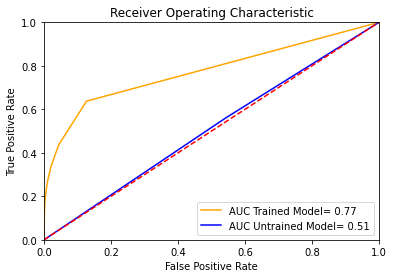

In [105]:
#plot models' roc curve
plot_model_perf(model, untrained_model, basset_dataloader_test, device)

2. We represent motifs as position weight matrices (PWMs). This is a matrix of size $4$ $\times$ the motif length, where the $(i,j)$th entry is a count of how often base-pair $i$ occurs at position $j$. Open the PWM for the CTCF motif, which can be found in `MA0139.1.jaspar`. Normalize this matrix so that each column sums to $1$.

In [28]:
!pip install biopython

     |████████████████████████████████| 2.3 MB 4.3 MB/s 


In [29]:
from Bio import motifs
from Bio.Seq import Seq

In [30]:
with open("/content/MA0139.1.jaspar") as f:
  for m in motifs.parse(f, "jaspar"):
    counts = m.counts
    m.weblogo("CTCF.pdf", format = "pdf", show_ends = False, show_fineprint = True, show_yaxis = False, show_errorbars = False)

In [31]:
pwm_ctcf = counts.normalize()

In [32]:
print(pwm_ctcf)

        0      1      2      3      4      5      6      7      8      9     10     11     12     13     14     15     16     17     18
A:   0.10   0.18   0.31   0.06   0.01   0.81   0.04   0.12   0.93   0.01   0.37   0.06   0.01   0.06   0.11   0.41   0.09   0.13   0.44
C:   0.32   0.16   0.05   0.88   0.99   0.01   0.58   0.47   0.01   0.00   0.00   0.01   0.00   0.01   0.81   0.01   0.53   0.35   0.20
G:   0.08   0.45   0.49   0.02   0.00   0.07   0.37   0.05   0.04   0.99   0.62   0.55   0.98   0.85   0.01   0.56   0.34   0.08   0.29
T:   0.50   0.20   0.15   0.04   0.00   0.10   0.01   0.36   0.02   0.00   0.01   0.37   0.01   0.08   0.07   0.02   0.04   0.44   0.06



3. In the methods section of the [paper](https://pubmed.ncbi.nlm.nih.gov/27197224/) (page 998), the authors describe how they converted each of the $300$ filters into normalized PWMs. First, for each filter, they determined the maximum activated value across the *dataset* (you may use a subset of the test set here). Compute these values.

In [33]:
print(m)

TF name	CTCF
Matrix ID	MA0139.1
Matrix:
        0      1      2      3      4      5      6      7      8      9     10     11     12     13     14     15     16     17     18
A:  87.00 167.00 281.00  56.00   8.00 744.00  40.00 107.00 851.00   5.00 333.00  54.00  12.00  56.00 104.00 372.00  82.00 117.00 402.00
C: 291.00 145.00  49.00 800.00 903.00  13.00 528.00 433.00  11.00   0.00   3.00  12.00   0.00   8.00 733.00  13.00 482.00 322.00 181.00
G:  76.00 414.00 449.00  21.00   0.00  65.00 334.00  48.00  32.00 903.00 566.00 504.00 890.00 775.00   5.00 507.00 307.00  73.00 266.00
T: 459.00 187.00 134.00  36.00   2.00  91.00  11.00 324.00  18.00   3.00   9.00 341.00   8.00  71.00  67.00  17.00  37.00 396.00  59.00





In [34]:
conv_layer = model.conv1
conv_layer = conv_layer.to(device)

max_act_mat = -100 * torch.ones(300)


In [35]:
max_act_mat.shape

torch.Size([300])

In [36]:
unfold = torch.nn.Unfold(kernel_size = (19,4), padding = (9,0), stride = 1)

with torch.no_grad():
  for _, batch in enumerate(tqdm(basset_dataloader_test)):
    batch_x = batch["sequence"].to(device)
    conv_out = conv_layer(batch_x)
    # print(conv_out.shape)
    for i in range(300):
      max_act_mat[i] = np.maximum(max_act_mat[i],torch.max(conv_out[:,i,:,0]).cpu().detach().numpy())

print(max_act_mat.shape)
print(max_act_mat)


100%|██████████| 1123/1123 [01:21<00:00, 13.77it/s]

torch.Size([300])
tensor([4.9700, 4.8929, 4.8372, 4.5354, 4.9796, 4.7282, 4.8245, 4.4463, 4.8523,
        4.8572, 4.6083, 5.0555, 5.0254, 4.7123, 4.4172, 5.0435, 5.7545, 4.9731,
        4.2831, 5.3378, 4.7958, 4.2009, 5.0374, 5.4140, 4.5781, 4.8891, 4.7411,
        4.6867, 4.9395, 4.3737, 4.5427, 4.2368, 4.8394, 4.6089, 4.4521, 4.6637,
        4.7382, 5.0788, 5.1028, 5.0574, 5.0675, 4.9962, 5.4123, 4.6317, 5.4619,
        4.9343, 4.7872, 4.9316, 5.1589, 4.7506, 4.4100, 4.3558, 4.5409, 4.7757,
        5.0973, 5.1993, 4.7863, 4.8345, 4.5571, 4.1687, 5.4508, 5.4500, 4.7653,
        4.7747, 5.1056, 4.9593, 4.9124, 4.7413, 5.8432, 4.8026, 4.3194, 4.7410,
        5.3293, 4.9093, 4.7543, 4.7217, 4.7356, 5.3756, 4.8163, 5.0583, 4.5049,
        5.0095, 5.0922, 5.1565, 5.3730, 5.1228, 5.1545, 5.1919, 5.0479, 4.8696,
        5.0396, 5.3449, 4.9375, 5.0782, 4.5718, 5.0748, 4.5006, 5.2899, 5.2331,
        4.4156, 5.1286, 4.8962, 4.6013, 5.5388, 5.5039, 4.7675, 5.0292, 4.3501,
        5.4168, 4.9573


4. Next, they counted the base-pair occurrences in the set of sequences that activate the filter to a value that is more than half of its maximum value.

  Note: You should use `torch.functional.unfold`.

In [37]:
pwm = torch.zeros(300,19,4)

In [38]:
unfold = torch.nn.Unfold(kernel_size = (19,4), padding = (9,0), stride = 1)

with torch.no_grad():
  for _, batch in enumerate(tqdm(basset_dataloader_test)):
    batch_x = batch["sequence"].to(device)
    conv_out = conv_layer(batch_x)

    print(conv_out.shape)
    print(conv_out.squeeze().shape)
    print(conv_out.squeeze().permute(0,2,1).shape)
    conv_out = conv_out.squeeze().permute(0,2,1).flatten(0,1)
    print(conv_out.shape)
    
    unfold_x = unfold(batch_x)
    N,_, L = unfold_x.shape
    print(N, L)
    unfold_x = unfold_x.reshape(N, 19, 4, L)
    print(unfold_x.shape)
    print(unfold_x.permute(0,3,1,2).flatten(0,1).shape)
    unfold_x = unfold_x.permute(0,3,1,2).flatten(0,1)
    max_thresh = max_act_mat.unsqueeze(0).repeat(conv_out.shape[0], 1)
    print(max_thresh.shape)
    print(max_thresh)
    threshold = max_thresh/2
    activ_seq = torch.gt(conv_out.cpu(),threshold)
    print(activ_seq.shape)

    for i in tqdm(range(300)):
      inds = activ_seq[:, i]
      base_pairs = unfold_x[inds]
      pwm_i = base_pairs.sum(dim = 0)
      print(pwm_i.shape)
      print(pwm_i)
      pwm[i, ...] +=pwm_i.cpu()
      break
    break

  0%|          | 0/1123 [00:00<?, ?it/s]

torch.Size([64, 300, 600, 1])
torch.Size([64, 300, 600])
torch.Size([64, 600, 300])
torch.Size([38400, 300])
64 600
torch.Size([64, 19, 4, 600])
torch.Size([38400, 19, 4])
torch.Size([38400, 300])
tensor([[4.9700, 4.8929, 4.8372,  ..., 4.7376, 4.9308, 4.9046],
        [4.9700, 4.8929, 4.8372,  ..., 4.7376, 4.9308, 4.9046],
        [4.9700, 4.8929, 4.8372,  ..., 4.7376, 4.9308, 4.9046],
        ...,
        [4.9700, 4.8929, 4.8372,  ..., 4.7376, 4.9308, 4.9046],
        [4.9700, 4.8929, 4.8372,  ..., 4.7376, 4.9308, 4.9046],
        [4.9700, 4.8929, 4.8372,  ..., 4.7376, 4.9308, 4.9046]])
torch.Size([38400, 300])



  0%|          | 0/1123 [00:00<?, ?it/s]

torch.Size([19, 4])
tensor([[229., 159., 115., 337.],
        [334., 146.,  46., 316.],
        [ 72., 132., 148., 490.],
        [283., 145.,  40., 376.],
        [ 95., 128., 172., 449.],
        [400., 161.,  77., 206.],
        [329., 142.,  70., 304.],
        [262., 126., 175., 282.],
        [345., 114., 184., 202.],
        [280.,  31.,  99., 435.],
        [312.,  34., 132., 367.],
        [267., 165., 127., 286.],
        [ 29., 163.,  35., 618.],
        [365., 163.,  94., 223.],
        [400.,  16., 187., 242.],
        [345.,  15., 389.,  96.],
        [ 13.,  81., 181., 570.],
        [557.,  52.,  97., 139.],
        [ 96., 295.,  60., 393.]], device='cuda:0')


In [39]:
pwm_i.shape

torch.Size([19, 4])

In [40]:
batch_x.shape

torch.Size([64, 1, 600, 4])

In [41]:
unfold = torch.nn.Unfold(kernel_size = (19,4), padding = (9,0), stride = 1)

with torch.no_grad():
  for _, batch in enumerate(tqdm(basset_dataloader_test)):
    batch_x = batch["sequence"].to(device)
    conv_out = conv_layer(batch_x)
    conv_out = conv_out.squeeze().permute(0,2,1).flatten(0,1)
    unfold_x = unfold(batch_x)
    N,_, L = unfold_x.shape
    unfold_x = unfold_x.reshape(N, 19, 4, L)
    unfold_x = unfold_x.permute(0,3,1,2).flatten(0,1)
    max = max_act_mat.unsqueeze(0).repeat(conv_out.shape[0], 1)
    threshold = max/2
    activ_seq = torch.gt(conv_out.cpu(),threshold)
    for i in range(300):
      inds = activ_seq[:, i]
      base_pairs = unfold_x[inds]
      pwm_i = base_pairs.sum(dim = 0)
      pwm[i, ...] +=pwm_i.cpu()
      

100%|██████████| 1123/1123 [03:40<00:00,  5.09it/s]


In [42]:
 pwm.shape

torch.Size([300, 19, 4])

In [43]:
pwm[0]

tensor([[211898., 165819., 104519., 329549.],
        [307782., 140395.,  56762., 308141.],
        [ 69048., 127682., 158451., 458916.],
        [265356., 148346.,  43570., 357644.],
        [ 93693., 128739., 178031., 415024.],
        [362698., 166875.,  70943., 215457.],
        [335356., 147633.,  68880., 264553.],
        [238865., 119372., 191304., 267340.],
        [338439., 103637., 202578., 172618.],
        [261354.,  33685., 113889., 408607.],
        [304992.,  43202., 147710., 321631.],
        [229362., 155182., 143297., 289694.],
        [ 27536., 155303.,  31721., 602975.],
        [332249., 167460.,  87462., 230297.],
        [405881.,  11106., 209228., 191166.],
        [319891.,  14111., 377345., 105848.],
        [  7032.,  74600., 208048., 527080.],
        [516857.,  56215., 116696., 126097.],
        [ 89466., 312913.,  50735., 361602.]])

In [44]:
pwm[i,:,:].shape

torch.Size([19, 4])

5. Given your 300 PWMs derived from your convolution filters, check to see if any of them are similar to the PWM for CTCF. You could quantify the similarity using *Pearson Correlation Coefficient*. Make a visualization of the PWM of the CTCF motif along with the most similar ones learned from the network. 

In [45]:
from scipy import stats as stats

In [46]:
pwm_ctcf_dict = dict(pwm_ctcf)

In [47]:
pwm_ctcf_arr = list(pwm_ctcf_dict.values())
pwm_ctcf_arr = np.array(pwm_ctcf_arr).T

In [48]:
pwm_ctcf_arr.shape

(19, 4)

In [49]:
flat_ctcf = pwm_ctcf_arr.flatten()
flat_ctcf.shape

(76,)

In [50]:
similarity_scores = []
for i in tqdm(range(300)):
  filter_pwm_norm = pwm[i,:,:]
  filter_pwm_norm /=  filter_pwm_norm.sum(axis=1)[:,np.newaxis]
  flat_filter = filter_pwm_norm.flatten()
  sim = stats.pearsonr(flat_ctcf, flat_filter)
  similarity_scores.append(sim)


100%|██████████| 300/300 [00:00<00:00, 5611.81it/s]


In [64]:
max(similarity_scores)

(0.7806102739969752, 9.244477685536505e-17)

In [65]:
similarity_scores = [x[0] for x in similarity_scores]
max(similarity_scores)

0.7806102739969752

In [55]:
most_sim_ind = similarity_scores.index(max(similarity_scores))
most_sim_conv_pwm = pwm[most_sim_ind, :,:]
most_sim_conv_pwm.shape

torch.Size([19, 4])

In [ ]:
len(set(similarity_scores))

In [ ]:
import matplotlib.pyplot as plt
plt.hist(similarity_scores, 300)

In [ ]:
np.isnan(similarity_scores).any()

In [120]:
top_2_score = sorted(similarity_scores)[-2]
print(top_2_score)
second_sim_ind = similarity_scores.index(top_2_score)

0.5874470076599283


In [118]:
most_sim_conv_pwm_2 = pwm[second_sim_ind, :, :]

# Fancy Sequence PLOTS

In [57]:
import seaborn as sns


In [111]:
most_sim_conv_pwm = most_sim_conv_pwm.numpy

In [113]:
most_sim_conv_pwm.shape

(19, 4)

In [68]:
alphabets = ["A", "C", "G", "T"]

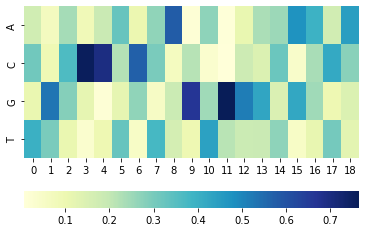

In [102]:
import matplotlib.pyplot as plt
ax = sns.heatmap(most_sim_conv_pwm.T, 
                 yticklabels = alphabets,
                 cbar_kws={"orientation": "horizontal"},
                 cmap="YlGnBu") 
plt.show()

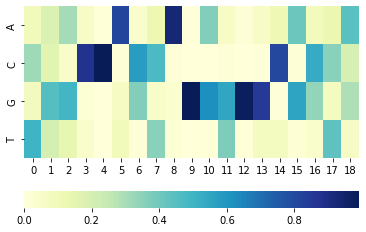

In [103]:
ax = sns.heatmap(pwm_ctcf_arr.T, 
                 yticklabels = alphabets,
                 cbar_kws={"orientation": "horizontal"},
                 cmap="YlGnBu") 
plt.show()

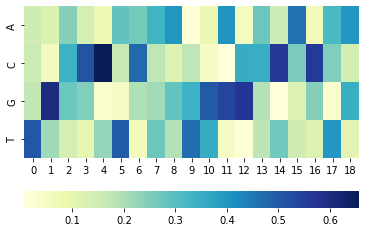

In [119]:
ax = sns.heatmap(most_sim_conv_pwm_2.T, 
                 yticklabels = alphabets,
                 cbar_kws={"orientation": "horizontal"},
                 cmap="YlGnBu") 
plt.show()

In [ ]:
import matplotlib.pyplot as plt
ax = sns.heatmap(most_sim_conv_pwm.T) # linewidth=0.5)
plt.show()

In [52]:
del max